

*   Desarrollar un modelo para clasificación de calidad en limones
*   Realizar una correcta partición de datos y extracción de características
*   Realizar una optimización de hiperparámetros o búsqueda de algoritmo









In [2]:
!pip install tensorflow

In [10]:
# Se importan las librerías necesarias
import os
import shutil
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Ruta a las imagenes
data_dir = "/content/drive/MyDrive/ComputerVision/Ejercicios/Semana12/Lemon_quality/"
san_dir = os.path.join(data_dir, 'good_quality/')
enf_dir = os.path.join(data_dir, 'bad_quality/')

# Obtiene listas de imágenes
san_imagenes = [os.path.join(san_dir, img) for img in os.listdir(san_dir)]
enf_imagenes = [os.path.join(enf_dir, img) for img in os.listdir(enf_dir)]

# Crea etiquetas (0 para sanas, 1 para enfermas)
san_etiquetas = [0] * len(san_imagenes)
enf_etiquetas = [1] * len(enf_imagenes)

imagenes = np.array(san_imagenes + enf_imagenes)
etiquetas = np.array(san_etiquetas + enf_etiquetas)

# Divide los datos en entrenamiento, validación y prueba (70% - 15% - 15%)
X_train, X_temp, y_train, y_temp = train_test_split(imagenes, etiquetas, test_size=0.3, stratify=etiquetas)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [12]:
# Función para normalizar una característica
def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features.reshape(-1, 1)).flatten()

# Función para asegurar que las imágenes tengan el mismo tamaño antes de extraer características
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_size)  # Redimensionamos a tamaño fijo
    return resized_image


In [14]:
# Función para extraer características de la imagen
def extract_features(image_path):
    image = preprocess_image(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Umbralización
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Equalización de histograma
    equalized = cv2.equalizeHist(gray)

    # Operaciones morfológicas
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(equalized, cv2.MORPH_OPEN, kernel)

    # HOG (ahora solo se obtiene un valor, sin visualizar)
    hog_features = hog(morph, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    hog_features = normalize_features(hog_features)

    # Histograma de intensidades
    hist = cv2.calcHist([morph], [0], None, [256], [0, 256]).flatten()
    hist = normalize_features(hist)

    # LBP
    lbp = local_binary_pattern(morph, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 59), range=(0, 58))
    lbp_hist = normalize_features(lbp_hist)

    # Momentos de Hu
    moments = cv2.moments(thresh)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_moments = normalize_features(hu_moments)

    # Concatenar todas las características
    features = np.hstack([hog_features, hist, lbp_hist, hu_moments])

    return features

# Extraemos características de las imágenes del dataset dividido
X_train_features = np.array([extract_features(img) for img in X_train])
X_val_features = np.array([extract_features(img) for img in X_val])
X_test_features = np.array([extract_features(img) for img in X_test])

print(f"Tamaño de las características (X_train): {X_train_features.shape}")
print(f"Tamaño de las características (X_val): {X_val_features.shape}")
print(f"Tamaño de las características (X_test): {X_test_features.shape}")

Tamaño de las características (X_train): (1453, 8421)
Tamaño de las características (X_val): (311, 8421)
Tamaño de las características (X_test): (312, 8421)


In [15]:
# Escala los datos
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_val_features = scaler.transform(X_val_features)
X_test_features = scaler.transform(X_test_features)

In [16]:
# Define el modelo con KerasTuner para optimizar hiperparámetros
def build_model(hp):
    model = models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu', input_shape=(X_train_features.shape[1],)))

    model.add(layers.Dense(1, activation='sigmoid'))  # Para clasificación binaria

    # Compila el modelo
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Configuración del tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='lemon_quality_optimization')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Búsqueda de hiperparámetros
tuner.search(X_train_features, y_train, epochs=10, validation_data=(X_val_features, y_val))

# Obtiene el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Evalua el mejor modelo en el conjunto de prueba
best_model.evaluate(X_test_features, y_test)

# Hace predicciones
y_pred = (best_model.predict(X_test_features) > 0.5).astype("int32")

Trial 21 Complete [00h 00m 06s]
val_accuracy: 0.9324758648872375

Best val_accuracy So Far: 0.9421221613883972
Total elapsed time: 00h 02m 42s
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9187 - loss: 0.2878  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


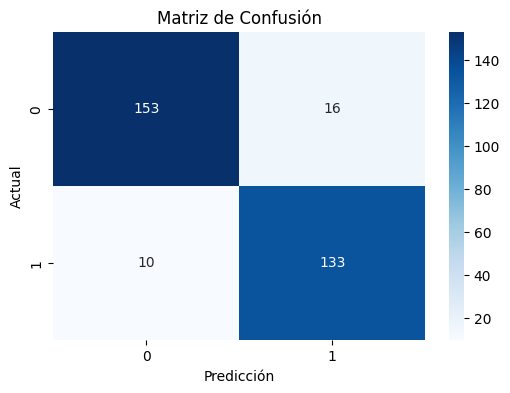

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       169
           1       0.89      0.93      0.91       143

    accuracy                           0.92       312
   macro avg       0.92      0.92      0.92       312
weighted avg       0.92      0.92      0.92       312



In [18]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.show()

# Métricas de clasificación
print(classification_report(y_test, y_pred))